# **0. Introduction**
With this notebook you can define:

1. Preprocessing method : If you want to perform scaling or not
2. Over / under sampling method.
3. Feature Selection Method
4. Methods for handle nans
5. Hyperparameters of the Pytorch Neural Network
6. Categorical preprocessing (using hash vectorizer)

In [1]:
# Import libraries

# Data Manipulation
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from category_encoders import HashingEncoder

# Data splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Feature Selection
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

# Models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import torch as th
from torch import Tensor
from torch.nn.parameter import Parameter

# Feature Selection
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Oversampling
from imblearn.over_sampling import SMOTE , SMOTENC , ADASYN , BorderlineSMOTE , KMeansSMOTE ,SVMSMOTE

# Metrics
from sklearn.metrics import confusion_matrix , f1_score , precision_score , recall_score , make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score , precision_recall_curve, average_precision_score , accuracy_score

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV

# Data imputation
from sklearn.impute import KNNImputer

# Feature importance
import shap

# Utils
from itertools import product
import json
import time
import warnings
import pickle
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")
# Set Numpy Seed
np.random.seed(0)
#plt.style.use('ggplot')
print('Libraries imported.')

Libraries imported.


In [2]:
# Define parameters of how to run the notebook
# Posible options
"""
GLOBAL_PARAMETERS = {'FEATURE_SELECTION' : ['XGBOOST' , 'VARIANCE_THRESHOLD' , 'F_CLASSIF' , 'RFE' , 'NONE' , 'ALL_FEATURE_SELECTION_METHODS'],
                    'SAMPLING' : ['SMOTE' , 'ADASYN' , 'BORDERLINE_SMOTE', 'NONE' , 'ALL_OVERSAMPLING_METHODS'],
                    'PERFORM_SCALING' : ['YES' , 'NO'],
                    'NAN_HANDLE' : ['DROP_ALL' , 'MASK_ALL' , 'DROP_PERCENT' , KNN],
                    'CATEGORICAL_FEATURES' : ['NONE' , 'HASH'],
                    'PYTORC_PARAMETERS' : {}}
"""
GLOBAL_PARAMETERS = {'FEATURE_SELECTION' :  'FIX',
                    'SAMPLING' : 'ADASYN' ,
                    'PERFORM_SCALING' : 'YES',
                    'NAN_HANDLE' : 'KNN' ,
                    'CATEGORICAL_FEATURES' : 'HASH',
                    'PYTORCH_PARAMETERS' : {'hidden_sizes' : [ [100 , 100 , 50 , 100 , 100]],
                                            'dropout_prob' : [0.5],
                                            'class_weights' : [[1.0 , 1.0]],
                                           'BATCH_SIZE' : [16]}}

# Assert that the selection is ok
assert GLOBAL_PARAMETERS['FEATURE_SELECTION'] in ['XGBOOST' , 'VARIANCE_THRESHOLD' , 'F_CLASSIF' , 'RFE' , 'NONE' , 'ALL_FEATURE_SELECTION_METHODS' , 'FIX']
assert GLOBAL_PARAMETERS['SAMPLING'] in ['SMOTE' , 'ADASYN' , 'BORDERLINE_SMOTE' , 'NONE' , 'ALL_OVERSAMPLING_METHODS']
assert GLOBAL_PARAMETERS['PERFORM_SCALING'] in ['YES' , 'NO']
assert GLOBAL_PARAMETERS['NAN_HANDLE'] in ['DROP_ALL' , 'MASK_ALL' , 'DROP_PERCENT' , 'KNN']
assert GLOBAL_PARAMETERS['CATEGORICAL_FEATURES'] in ['NONE' , 'HASH']

print('GLOBAL PARAMETERS:')
for _ in GLOBAL_PARAMETERS.keys():
    print(_ , ':' , GLOBAL_PARAMETERS[_])

MODEL_NAME = 'Best_Pytorch_Model'
print('\nExperiment Name:' ,MODEL_NAME)

GLOBAL PARAMETERS:
FEATURE_SELECTION : FIX
SAMPLING : ADASYN
PERFORM_SCALING : YES
NAN_HANDLE : KNN
CATEGORICAL_FEATURES : HASH
PYTORCH_PARAMETERS : {'hidden_sizes': [[100, 100, 50, 100, 100]], 'dropout_prob': [0.5], 'class_weights': [[1.0, 1.0]], 'BATCH_SIZE': [16]}

Experiment Name: Best_Pytorch_Model


In [3]:
# Load data
input_path = r'..\data'
input_filename = r'\reduced_op_UK_merged_data_final_21062024.csv'
df = pd.read_csv(input_path + input_filename , decimal = '.' , sep = ';')
df

,record_id,data_group,sex,age,bmi,active_smoking,pack_years,alcohol_abuse,real_function_ckd_stages,preoperative_hemoglobin_level,...,approach,conversion,type_of_anastomosis -> das von UK sind alles Ileocolonic anastomosis,anastomotic_technique,anastomotic_configuration,protective_stomy,surgeon_experience,anastomotic_leackage,BIHistoryOfIschaemicHeartDisease,BIHistoryOfDiabetes
0,5921,clarunisclaraspita,1.0,87.0,NaN,1.0,25.0,2.0,5.0,9.6,...,1.0,NaN,3.0,2.0,1.0,3.0,1.0,0,0,0
1,59231,clarunisclaraspita,1.0,53.0,19.2,1.0,35.0,3.0,1.0,11.3,...,3.0,NaN,3.0,1.0,3.0,3.0,1.0,0,0,0
2,592-82,clarunisclaraspita,2.0,71.0,18.8,0.0,NaN,3.0,1.0,13.7,...,3.0,0.0,3.0,NaN,1.0,3.0,1.0,0,0,0
3,592-92,clarunisclaraspita,1.0,39.0,22.4,0.0,0.0,3.0,2.0,11.9,...,3.0,0.0,3.0,1.0,3.0,3.0,1.0,0,0,0
4,59251,clarunisclaraspita,1.0,67.0,17.2,1.0,75.0,3.0,1.0,7.7,...,3.0,NaN,3.0,1.0,3.0,3.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,473-772,university_wrzburg,2.0,24.0,20.4,0.0,NaN,3.0,1.0,13.6,...,1.0,NaN,3.0,2.0,2.0,3.0,1.0,0,0,0
5907,473-806,university_wrzburg,2.0,87.0,32.0,0.0,NaN,3.0,4.0,NaN,...,3.0,NaN,3.0,2.0,2.0,3.0,1.0,0,0,0
5908,473-808,university_wrzburg,2.0,74.0,22.7,1.0,20.0,3.0,1.0,9.7,...,3.0,NaN,3.0,1.0,3.0,3.0,1.0,0,0,1
5909,473-830,university_wrzburg,1.0,85.0,24.3,0.0,NaN,3.0,2.0,13.2,...,3.0,NaN,3.0,2.0,2.0,3.0,1.0,0,0,0


In [4]:
# Show group distribution
df['data_group'].value_counts()

uk                    3041
university_wrzburg     647
university_dalhous     340
university_of_east     314
military_universit     294
university_vilnius     234
university_basel       226
university_hamburg     220
university_las_veg     173
kantonspital_liest     106
universitt_innsbru     103
gzo_wetzikon            90
emmental_hospital       67
clarunisclaraspita      56
Name: data_group, dtype: int64

In [5]:
# Save total of data groups
clinics = df['data_group'].unique().tolist()
clinics

['clarunisclaraspita',
 'emmental_hospital',
 'gzo_wetzikon',
 'kantonspital_liest',
 'military_universit',
 'uk',
 'universitt_innsbru',
 'university_basel',
 'university_dalhous',
 'university_hamburg',
 'university_las_veg',
 'university_of_east',
 'university_vilnius',
 'university_wrzburg']

In [6]:
# Print columns of the data
df.columns.tolist()

['record_id',
 'data_group',
 'sex',
 'age',
 'bmi',
 'active_smoking',
 'pack_years',
 'alcohol_abuse',
 'real_function_ckd_stages',
 'preoperative_hemoglobin_level',
 'preoperative_leukocyte_count',
 'preoperative_albumin_level',
 'preoperative_crp_level',
 'liver_metastasis_at_time_of_anastomosis',
 'neoadjuvant_therapy',
 'preoperative_use_of_immunosuppressive_drugs',
 'preoperative_steroid_use',
 'dosage_of_steroids',
 'preoperative_nsaids_use',
 'preoperative_blood_transfusion',
 'tnf_alpha_inhib',
 'asa_score',
 'prior_abdominal_surgery',
 'indication',
 'operation',
 'emergency_surgery',
 'perforation',
 'approach',
 'conversion',
 'type_of_anastomosis -> das von UK sind alles  Ileocolonic anastomosis',
 'anastomotic_technique',
 'anastomotic_configuration',
 'protective_stomy',
 'surgeon_experience',
 'anastomotic_leackage',
 'BIHistoryOfIschaemicHeartDisease',
 'BIHistoryOfDiabetes']

In [7]:
# Drop columns to omit
drop_columns = ['record_id']
df = df.drop(columns = drop_columns)

In [8]:
# Define target variable
TARGET = ['anastomotic_leackage']

# **1. NAN Handle**

Here is defined the process of how to handle nan values.

1. If DROP_ALL, then all rows with nans are removed 
2. If MASK_ALL, then all rows with nans are masked with -1
3. If DROP_PERCENT, then only features with a percent of missing are dropped

In [9]:
# Encode data_group column
if 'data_group' in df.columns.tolist():
    clinics_2 = df['data_group'].unique().tolist()
    code_clinics = {v : k for k , v in enumerate(clinics_2)}
    df['data_group_encoded'] = df['data_group'].map(code_clinics)
    df = df.drop(columns = ['data_group'])

df

,sex,age,bmi,active_smoking,pack_years,alcohol_abuse,real_function_ckd_stages,preoperative_hemoglobin_level,preoperative_leukocyte_count,preoperative_albumin_level,...,conversion,type_of_anastomosis -> das von UK sind alles Ileocolonic anastomosis,anastomotic_technique,anastomotic_configuration,protective_stomy,surgeon_experience,anastomotic_leackage,BIHistoryOfIschaemicHeartDisease,BIHistoryOfDiabetes,data_group_encoded
0,1.0,87.0,NaN,1.0,25.0,2.0,5.0,9.6,6.4,0.0,...,NaN,3.0,2.0,1.0,3.0,1.0,0,0,0,0
1,1.0,53.0,19.2,1.0,35.0,3.0,1.0,11.3,12.4,0.0,...,NaN,3.0,1.0,3.0,3.0,1.0,0,0,0,0
2,2.0,71.0,18.8,0.0,NaN,3.0,1.0,13.7,9.0,0.0,...,0.0,3.0,NaN,1.0,3.0,1.0,0,0,0,0
3,1.0,39.0,22.4,0.0,0.0,3.0,2.0,11.9,8.8,0.0,...,0.0,3.0,1.0,3.0,3.0,1.0,0,0,0,0
4,1.0,67.0,17.2,1.0,75.0,3.0,1.0,7.7,8.6,0.0,...,NaN,3.0,1.0,3.0,3.0,1.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,2.0,24.0,20.4,0.0,NaN,3.0,1.0,13.6,4.9,NaN,...,NaN,3.0,2.0,2.0,3.0,1.0,0,0,0,13
5907,2.0,87.0,32.0,0.0,NaN,3.0,4.0,NaN,NaN,NaN,...,NaN,3.0,2.0,2.0,3.0,1.0,0,0,0,13
5908,2.0,74.0,22.7,1.0,20.0,3.0,1.0,9.7,9.2,NaN,...,NaN,3.0,1.0,3.0,3.0,1.0,0,0,1,13
5909,1.0,85.0,24.3,0.0,NaN,3.0,2.0,13.2,4.7,NaN,...,NaN,3.0,2.0,2.0,3.0,1.0,0,0,0,13


In [10]:
if GLOBAL_PARAMETERS['NAN_HANDLE'] == 'MASK_ALL':
    print('All features masked as -1')
    df = df.fillna(-1)
if GLOBAL_PARAMETERS['NAN_HANDLE'] == 'DROP_ALL':
    percent_of_missing = pd.DataFrame((df.replace(-1 , np.nan).isnull().sum() / df.shape[0]).sort_values(ascending = False))
    print(percent_of_missing)
    to_drop_missing_columns = percent_of_missing[percent_of_missing[0] > 0.2].index.tolist()
    print('Columns deleted by missing values:' , to_drop_missing_columns)
    df = df.drop(columns = to_drop_missing_columns)
    df = df.dropna()
    print('Rows with nan dropped')
if GLOBAL_PARAMETERS['NAN_HANDLE'] == 'DROP_PERCENT':
    print('Maintaining features with certain percent of NaNs')
    percent_of_missing = pd.DataFrame((df.replace(-1 , np.nan).isnull().sum() / df.shape[0]).sort_values(ascending = False))
    print(percent_of_missing)
    to_drop_missing_columns = percent_of_missing[percent_of_missing[0] > 0.2].index.tolist()
    print('Columns deleted by missing values:' , to_drop_missing_columns)
    df = df.drop(columns = to_drop_missing_columns)
if GLOBAL_PARAMETERS['NAN_HANDLE'] == 'KNN':
    print('Imputing data using KNN')
    percent_of_missing = pd.DataFrame((df.replace(-1 , np.nan).isnull().sum() / df.shape[0]).sort_values(ascending = False))
    print(percent_of_missing)
    to_drop_missing_columns = percent_of_missing[percent_of_missing[0] > 0.3].index.tolist()
    print('Columns deleted by missing values:' , to_drop_missing_columns)
    imputer = KNNImputer(n_neighbors = 10)
    df = pd.DataFrame(imputer.fit_transform(df) , columns = df.columns.tolist())
df

Imputing data using KNN
                                                           0
pack_years                                          0.703265
preoperative_albumin_level                          0.669768
liver_metastasis_at_time_of_anastomosis             0.588733
tnf_alpha_inhib                                     0.582643
preoperative_nsaids_use                             0.577736
real_function_ckd_stages                            0.570969
preoperative_leukocyte_count                        0.566402
alcohol_abuse                                       0.553037
protective_stomy                                    0.536457
preoperative_blood_transfusion                      0.507528
dosage_of_steroids                                  0.506513
preoperative_use_of_immunosuppressive_drugs         0.460497
preoperative_steroid_use                            0.459313
perforation                                         0.416173
conversion                                          0.402977


,sex,age,bmi,active_smoking,pack_years,alcohol_abuse,real_function_ckd_stages,preoperative_hemoglobin_level,preoperative_leukocyte_count,preoperative_albumin_level,...,conversion,type_of_anastomosis -> das von UK sind alles Ileocolonic anastomosis,anastomotic_technique,anastomotic_configuration,protective_stomy,surgeon_experience,anastomotic_leackage,BIHistoryOfIschaemicHeartDisease,BIHistoryOfDiabetes,data_group_encoded
0,1.0,87.0,23.96,1.0,25.0,2.0,5.0,9.60,6.40,0.0,...,0.5,3.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0
1,1.0,53.0,19.20,1.0,35.0,3.0,1.0,11.30,12.40,0.0,...,0.5,3.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0
2,2.0,71.0,18.80,0.0,20.7,3.0,1.0,13.70,9.00,0.0,...,0.0,3.0,1.7,1.0,3.0,1.0,0.0,0.0,0.0,0.0
3,1.0,39.0,22.40,0.0,0.0,3.0,2.0,11.90,8.80,0.0,...,0.0,3.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0
4,1.0,67.0,17.20,1.0,75.0,3.0,1.0,7.70,8.60,0.0,...,0.6,3.0,1.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,2.0,24.0,20.40,0.0,1.0,3.0,1.0,13.60,4.90,0.0,...,0.2,3.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0,13.0
5907,2.0,87.0,32.00,0.0,20.3,3.0,4.0,9.61,7.27,0.0,...,0.4,3.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0,13.0
5908,2.0,74.0,22.70,1.0,20.0,3.0,1.0,9.70,9.20,0.0,...,0.5,3.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,13.0
5909,1.0,85.0,24.30,0.0,15.9,3.0,2.0,13.20,4.70,0.0,...,0.5,3.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0,13.0


In [12]:
# Save imputer
imputer_path = r'..\models\KNN_Imputer.sav'
pickle.dump(imputer , open(imputer_path , 'wb'))
print('Object saved -->' , imputer_path)

Object saved --> ..\models\KNN_Imputer.sav


In [13]:
# Define numeric and categorical columns
num_columns = ['age' , 'bmi' , 'pack_years' , 'preoperative_hemoglobin_level' , 'preoperative_leukocyte_count',
              'preoperative_albumin_level' , 'preoperative_crp_level' , 'dosage_of_steroids']
num_columns = [i for i in num_columns if i in df.columns.tolist()]
ordinal_columns = ['real_function_ckd_stages' , 'charlson_comorbidity_index' ,
                  'asa_score' , 'surgeon_experience']
ordinal_columns = [i for i in ordinal_columns if i in df.columns.tolist()]
cat_columns = df.drop(columns = num_columns + TARGET + ordinal_columns).columns.tolist()
cat_columns

['sex',
 'active_smoking',
 'alcohol_abuse',
 'liver_metastasis_at_time_of_anastomosis',
 'neoadjuvant_therapy',
 'preoperative_use_of_immunosuppressive_drugs',
 'preoperative_steroid_use',
 'preoperative_nsaids_use',
 'preoperative_blood_transfusion',
 'tnf_alpha_inhib',
 'prior_abdominal_surgery',
 'indication',
 'operation',
 'emergency_surgery',
 'perforation',
 'approach',
 'conversion',
 'type_of_anastomosis -> das von UK sind alles  Ileocolonic anastomosis',
 'anastomotic_technique',
 'anastomotic_configuration',
 'protective_stomy',
 'BIHistoryOfIschaemicHeartDisease',
 'BIHistoryOfDiabetes',
 'data_group_encoded']

# **2. Scaling**
1. If YES, then MinMaxScaler is used to numeric features.
2. If NO, then no scaling is used.

In [14]:
if GLOBAL_PARAMETERS['PERFORM_SCALING'] == 'YES':
    print('Scaling performed\n')
    # Create scaler and one hot encoding obects
    numeric_scaler = MinMaxScaler()
    # Fit objects
    numeric_scaler.fit(df[num_columns])
    # Transform data
    aux_numeric = pd.DataFrame(numeric_scaler.transform(df[num_columns]) , columns = df[num_columns].columns.tolist())
    # Concat data
    df = pd.concat([aux_numeric,
                    df[ordinal_columns].fillna(-1).reset_index(drop = True),
                    df[cat_columns].reset_index(drop = True),
                    df[TARGET].fillna(0).reset_index(drop = True)] , axis = 1)
if GLOBAL_PARAMETERS['PERFORM_SCALING'] == 'NO':
    print('No scaling performed\n')
    #for i in range(len(train_set)):
        #train_set[i] = train_set[i].drop(columns = ['data_group']).fillna(-1)
        #test_set[i] = test_set[i].drop(columns = ['data_group']).fillna(-1)

df

Scaling performed



,age,bmi,pack_years,preoperative_hemoglobin_level,preoperative_leukocyte_count,preoperative_albumin_level,preoperative_crp_level,dosage_of_steroids,real_function_ckd_stages,asa_score,...,approach,conversion,type_of_anastomosis -> das von UK sind alles Ileocolonic anastomosis,anastomotic_technique,anastomotic_configuration,protective_stomy,BIHistoryOfIschaemicHeartDisease,BIHistoryOfDiabetes,data_group_encoded,anastomotic_leackage
0,0.835294,0.212811,0.004630,0.377119,0.047077,0.0,0.013769,0.00,5.0,2.9,...,1.0,0.5,3.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0
1,0.435294,0.128114,0.006481,0.449153,0.092635,0.0,0.010327,0.00,1.0,2.0,...,3.0,0.5,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0
2,0.647059,0.120996,0.003833,0.550847,0.066819,0.0,0.008606,0.04,1.0,4.0,...,3.0,0.0,3.0,1.7,1.0,3.0,0.0,0.0,0.0,0.0
3,0.270588,0.185053,0.000000,0.474576,0.065300,0.0,0.049914,0.00,2.0,2.0,...,3.0,0.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0
4,0.600000,0.092527,0.013889,0.296610,0.063781,0.0,0.080895,0.00,1.0,4.0,...,3.0,0.6,3.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,0.094118,0.149466,0.000185,0.546610,0.035687,0.0,0.009122,0.00,1.0,2.0,...,1.0,0.2,3.0,2.0,2.0,3.0,0.0,0.0,13.0,0.0
5907,0.835294,0.355872,0.003759,0.377542,0.053683,0.0,0.044647,0.00,4.0,3.0,...,3.0,0.4,3.0,2.0,2.0,3.0,0.0,0.0,13.0,0.0
5908,0.682353,0.190391,0.003704,0.381356,0.068337,0.0,0.053924,0.00,1.0,3.0,...,3.0,0.5,3.0,1.0,3.0,3.0,0.0,1.0,13.0,0.0
5909,0.811765,0.218861,0.002944,0.529661,0.034169,0.0,0.033046,0.00,2.0,3.0,...,3.0,0.5,3.0,2.0,2.0,3.0,0.0,0.0,13.0,0.0


In [16]:
# Save Scaler
scaler_path = r'..\models\Scaler.sav'
pickle.dump(numeric_scaler , open(scaler_path , 'wb'))
print('Object saved -->' , scaler_path)

Object saved --> ..\models\Scaler.sav


# **3 Feature Selection**

1. If XGBOOST, then a XGBClassifier is trained and select the top n% (default 80%) of the features
2. If VARIANCE_THRESHOLD, then Scikit Learn Variance Threshold with default parameters is applied
3. If F_CLASSIF, then ANOVA is applied.
4. If RFE, then Recursive Feature Elimination is applied.
5. If LASSO, then Lasso model is applied.
6. If NONE, then no feature selection is applied

In [17]:
if GLOBAL_PARAMETERS['FEATURE_SELECTION'] == 'XGBOOST':
    print('Feature Selection : XGBoost Feature Importance')
    # Create XGB Model
    feature_selection_model = XGBClassifier().fit(df.drop(columns = TARGET),
                                                  df[TARGET])
    # Extract feature importance from the model
    feature_importances = pd.DataFrame({'Feature' : feature_selection_model.feature_names_in_.tolist(),
                                       'Importance' : feature_selection_model.feature_importances_.tolist()}).sort_values(by = 'Importance' , ascending = False).reset_index(drop = True)
    feature_importances['Cumulative_Importance'] = feature_importances['Importance'].cumsum()
    print('Feature Importance for XGBoost:')
    print(feature_importances)
    # Select top % of features
    threshold = 0.8
    features_selected = feature_importances[feature_importances['Cumulative_Importance'] <= threshold]['Feature'].tolist()
    print('Features Selected:' , features_selected)
    df = df[features_selected + TARGET]
if GLOBAL_PARAMETERS['FEATURE_SELECTION'] == 'VARIANCE_THRESHOLD':
    print('Feature Selection : Variance Threshold')
    # Create the object for selection
    feature_selection_model = VarianceThreshold()
    feature_selection_model.fit(df.drop(columns = TARGET),
                                df[TARGET])
    features_selected = feature_selection_model.feature_names_in_.tolist()
    print('Features Selected:' , features_selected)
    df = df[features_selected + TARGET]
if GLOBAL_PARAMETERS['FEATURE_SELECTION'] == 'F_CLASSIF':
    print('Feature Selection : ANOVA')
    threshold = int(0.6 * df.drop(columns = TARGET).shape[1]) # % of features to maintain
    print('Maintaining' , threshold , 'features')
    feature_selection_model = SelectKBest(f_classif,
                                          k=threshold)
    feature_selection_model.fit(df.drop(columns = TARGET),
                                df[TARGET])
    features_selected = feature_selection_model.get_feature_names_out().tolist()
    print('Features Selected:' , features_selected)
    df = df[features_selected + TARGET]
if GLOBAL_PARAMETERS['FEATURE_SELECTION'] == 'RFE':
    print('Feature Selection : RFE')
    threshold = int(0.6 * df.drop(columns = TARGET).shape[1]) # % of features to maintain
    feature_selection_model = RFECV(
                                    estimator = XGBClassifier(),
                                    step = 1,
                                    cv = StratifiedKFold(5),
                                    scoring = "f1_macro",
                                    min_features_to_select = threshold,
                                    n_jobs = -1,
                                )
    feature_selection_model.fit(df.drop(columns = TARGET),
                                df[TARGET])
    features_selected = feature_selection_model.get_feature_names_out().tolist()
    print('Features Selected:' , features_selected)
    df = df[features_selected + TARGET]
if GLOBAL_PARAMETERS['FEATURE_SELECTION'] == 'NONE':
    print('No Feature Selection applied')
if GLOBAL_PARAMETERS['FEATURE_SELECTION'] == 'FIX':
    print('Fixed selection')
    selected_features = ['age' ,'preoperative_albumin_level', 'bmi', 'preoperative_hemoglobin_level' ,'pack_years',
                         'sex' , 'neoadjuvant_therapy' , 'preoperative_use_of_immunosuppressive_drugs' , 'tnf_alpha_inhib' , 
                         'emergency_surgery' , 'approach' , 'anastomotic_leackage' , 'preoperative_steroid_use' , 'preoperative_nsaids_use',
                         'active_smoking' , 'liver_metastasis_at_time_of_anastomosis' , 'BIHistoryOfDiabetes' , 'preoperative_blood_transfusion' ,
                         'perforation' , 'anastomotic_technique' , 'surgeon_experience' , 'conversion' , 'anastomotic_configuration' , 'protective_stomy' , 
                         'BIHistoryOfIschaemicHeartDisease' , 'alcohol_abuse' , 'asa_score']
    valid_features = [i for i in selected_features if i in df.columns.tolist()]
    df = df[valid_features]
    
print('Selected Features' , ':' , df.columns.tolist())

Fixed selection
Selected Features : ['age', 'preoperative_albumin_level', 'bmi', 'preoperative_hemoglobin_level', 'pack_years', 'sex', 'neoadjuvant_therapy', 'preoperative_use_of_immunosuppressive_drugs', 'tnf_alpha_inhib', 'emergency_surgery', 'approach', 'anastomotic_leackage', 'preoperative_steroid_use', 'preoperative_nsaids_use', 'active_smoking', 'liver_metastasis_at_time_of_anastomosis', 'BIHistoryOfDiabetes', 'preoperative_blood_transfusion', 'perforation', 'anastomotic_technique', 'surgeon_experience', 'conversion', 'anastomotic_configuration', 'protective_stomy', 'BIHistoryOfIschaemicHeartDisease', 'alcohol_abuse', 'asa_score']


In [18]:
# Re define selected categorical and numerical columns
new_num_columns = []
new_cat_columns = []
new_num_columns.append([i for i in num_columns if i in df.columns.tolist()])
new_cat_columns.append([i for i in df.columns.tolist() if i not in new_num_columns[0] and i not in TARGET])
print('New Numeric Features:' , new_num_columns)
print('New Categrocial Features:' , new_cat_columns)

New Numeric Features: [['age', 'bmi', 'pack_years', 'preoperative_hemoglobin_level', 'preoperative_albumin_level']]
New Categrocial Features: [['sex', 'neoadjuvant_therapy', 'preoperative_use_of_immunosuppressive_drugs', 'tnf_alpha_inhib', 'emergency_surgery', 'approach', 'preoperative_steroid_use', 'preoperative_nsaids_use', 'active_smoking', 'liver_metastasis_at_time_of_anastomosis', 'BIHistoryOfDiabetes', 'preoperative_blood_transfusion', 'perforation', 'anastomotic_technique', 'surgeon_experience', 'conversion', 'anastomotic_configuration', 'protective_stomy', 'BIHistoryOfIschaemicHeartDisease', 'alcohol_abuse', 'asa_score']]


# **4. Categorical Features Preprocessing**

In [19]:
if GLOBAL_PARAMETERS['CATEGORICAL_FEATURES'] == 'NONE':
    print('No categorical features processing')
if GLOBAL_PARAMETERS['CATEGORICAL_FEATURES'] == 'HASH':
    print('Using Feature Hash')
    hasher = HashingEncoder(cols = new_cat_columns[0], n_components = 10).fit(df.drop(columns = TARGET) , df[TARGET])
    df = pd.concat([hasher.transform(df.drop(columns = TARGET)),
                    df[TARGET]] , axis = 1)
df

Using Feature Hash


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,age,preoperative_albumin_level,bmi,preoperative_hemoglobin_level,pack_years,anastomotic_leackage
0,12,0,3,0,0,1,0,0,5,0,0.835294,0.0,0.212811,0.377119,0.004630,0.0
1,11,0,2,0,0,4,0,0,4,0,0.435294,0.0,0.128114,0.449153,0.006481,0.0
2,9,0,2,0,1,3,0,1,5,0,0.647059,0.0,0.120996,0.550847,0.003833,0.0
3,10,0,2,1,0,4,0,0,4,0,0.270588,0.0,0.185053,0.474576,0.000000,0.0
4,6,0,2,0,0,4,0,0,8,1,0.600000,0.0,0.092527,0.296610,0.013889,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,10,0,5,1,0,2,0,0,3,0,0.094118,0.0,0.149466,0.546610,0.000185,0.0
5907,11,0,4,0,0,4,0,1,1,0,0.835294,0.0,0.355872,0.377542,0.003759,0.0
5908,10,0,2,0,0,5,0,0,4,0,0.682353,0.0,0.190391,0.381356,0.003704,0.0
5909,12,0,3,0,0,4,0,0,2,0,0.811765,0.0,0.218861,0.529661,0.002944,0.0


In [20]:
# Save Hasher
hasher_path = r'..\models\Hasher.sav'
pickle.dump(hasher , open(hasher_path , 'wb'))
print('Object saved -->' , hasher_path)

Object saved --> ..\models\Hasher.sav


In [21]:
new_cat_columns

[['sex',
  'neoadjuvant_therapy',
  'preoperative_use_of_immunosuppressive_drugs',
  'tnf_alpha_inhib',
  'emergency_surgery',
  'approach',
  'preoperative_steroid_use',
  'preoperative_nsaids_use',
  'active_smoking',
  'liver_metastasis_at_time_of_anastomosis',
  'BIHistoryOfDiabetes',
  'preoperative_blood_transfusion',
  'perforation',
  'anastomotic_technique',
  'surgeon_experience',
  'conversion',
  'anastomotic_configuration',
  'protective_stomy',
  'BIHistoryOfIschaemicHeartDisease',
  'alcohol_abuse',
  'asa_score']]

# **4. Sampling Method**

Depending of the over/under sampling model is selected, then the object is applied

In [22]:
if GLOBAL_PARAMETERS['SAMPLING'] == 'SMOTE':
    print('Oversampling with SMOTE')
    X = df.drop(columns = TARGET)
    Y =df[TARGET]
    oversampler = SMOTE()
    X_res , Y_res = oversampler.fit_resample(X , Y)
    df = pd.concat([X_res ,
                    Y_res] , axis = 1)
if GLOBAL_PARAMETERS['SAMPLING'] == 'ADASYN':
    print('Oversampling with ADASYN')
    X = df.drop(columns = TARGET)
    Y = df[TARGET]
    oversampler = ADASYN()
    X_res , Y_res = oversampler.fit_resample(X , Y)
    df = pd.concat([X_res ,
                    Y_res] , axis = 1)
if GLOBAL_PARAMETERS['SAMPLING'] == 'BORDERLINE_SMOTE':
    print('Oversampling with Borderline SMOTE')
    X = df.drop(columns = TARGET)
    Y = df[TARGET]
    oversampler = BorderlineSMOTE(random_state=42)
    X_res , Y_res = oversampler.fit_resample(X , Y)
    df = pd.concat([X_res ,
                    Y_res] , axis = 1)
if GLOBAL_PARAMETERS['SAMPLING'] == 'NONE':
    print('No oversampling applied')

df

Oversampling with ADASYN


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,age,preoperative_albumin_level,bmi,preoperative_hemoglobin_level,pack_years,anastomotic_leackage
0,12,0,3,0,0,1,0,0,5,0,0.835294,0.0,0.212811,0.377119,0.004630,0.0
1,11,0,2,0,0,4,0,0,4,0,0.435294,0.0,0.128114,0.449153,0.006481,0.0
2,9,0,2,0,1,3,0,1,5,0,0.647059,0.0,0.120996,0.550847,0.003833,0.0
3,10,0,2,1,0,4,0,0,4,0,0.270588,0.0,0.185053,0.474576,0.000000,0.0
4,6,0,2,0,0,4,0,0,8,1,0.600000,0.0,0.092527,0.296610,0.013889,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11016,9,0,3,0,0,4,0,0,3,1,0.806494,0.0,0.318263,0.380742,0.002526,1.0
11017,9,0,3,0,0,4,0,0,3,1,0.766012,0.0,0.305562,0.389642,0.003221,1.0
11018,9,0,3,0,0,4,0,0,3,1,0.820435,0.0,0.323661,0.381727,0.002028,1.0
11019,9,0,3,0,0,4,0,0,3,1,0.788817,0.0,0.194544,0.385523,0.001364,1.0


# **5. Model Training and Evaluation**

In [23]:
# Define functions for evaluation metrics
def calculate_confusion_matrix(true_labels, predicted_labels):
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

    return tn, tp, fp, fn

# Define function that takes confusion matrix an compute required metrics
def get_metrics(TN,TP,FP,FN):

    acc = (TN+TP)/(TN+TP+FN+FP)
    precision = TP / (TP + FP)

    # Calculate recall
    recall = TP / (TP + FN)
    # Calulcate specificity
    specificity = TN / (TN + FP)

    # Calculate False Negative Rate
    FNR = FN / (FN + TP)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall)

    return acc, precision, recall, f1 , specificity , FNR

In [24]:
# Function to smooth the ROC curve using a moving average
def smooth_roc_curve(fpr, tpr, window_size=5):
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
    df_smoothed = df.rolling(window=window_size).mean().dropna()
    # Add (1,1) point at the end
    df_smoothed = pd.concat([df_smoothed,
                             pd.DataFrame({'fpr' : [1] , 'tpr' : [1]})] , axis = 0)
    return df_smoothed['fpr'].values, df_smoothed['tpr'].values


# Function to smooth the Precision Recall curve using a moving average
def smooth_precision_curve(precision, recall, window_size=5):
    df = pd.DataFrame({'precision': precision, 'recall': recall})
    df_smoothed = df.rolling(window=window_size).mean().dropna()
    # Add (1,0) point at the end
    df_smoothed = pd.concat([df_smoothed,
                             pd.DataFrame({'precision' : [1] , 'recall' : [0]})] , axis = 0)
    return df_smoothed['precision'].values, df_smoothed['recall'].values

In [25]:
# Define fully conected model
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(FullyConnectedModel, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.dropout_prob = dropout_prob

        layers = []
        # Create the hidden layers with linear, batch normalization, and dropout
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(p=self.dropout_prob))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        # Output layer with softmax activation
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Softmax(dim = 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Define function to save pytorch model for early stopping
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

# Define function to load best early stopping pytorch model to continue with the evaluation
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [27]:
# Training loop
results_test = pd.DataFrame()
results_train = pd.DataFrame()
skf = StratifiedKFold(2)
# Extract total combinations
num_combinations = len(list(product(*GLOBAL_PARAMETERS['PYTORCH_PARAMETERS'].values())))
all_combinations = [
    {key: value for key, value in zip(GLOBAL_PARAMETERS['PYTORCH_PARAMETERS'].keys(), combo)}
    for combo in product(*GLOBAL_PARAMETERS['PYTORCH_PARAMETERS'].values())]
# Loop throught all pytorch parameters
for i in range(len(all_combinations)):
    print('#' * 50)
    print('Combination' , i + 1, 'of' , num_combinations)
    print('Parameters -->' , all_combinations[i])
    # Loop throgut test clinics
    for ii , (train_index , test_index) in enumerate(skf.split(df.drop(columns = TARGET) , df[TARGET])):
        print('-' * 50)
        print('Fold' , ii + 1 , 'of 5')
        
        # Define X and Y in both train and test sets
        X_train = df.loc[train_index].drop(columns = TARGET)
        Y_train = df.loc[train_index][TARGET]

        X_test = df.loc[test_index].drop(columns = TARGET)
        Y_test = df.loc[test_index][TARGET]
        
        # Convert data to Pytorch tensors
        x_train_tensor = torch.FloatTensor(X_train.values)
        x_test_tensor = torch.FloatTensor(X_test.values)

        y_train_tensor = torch.LongTensor([z[0] for z in Y_train.values.tolist()])
        y_test_tensor = torch.LongTensor([z[0] for z in Y_test.values.tolist()])

        dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = all_combinations[i]['BATCH_SIZE'], shuffle=True)
        dataset_size = len(dataloader.dataset)
        
        # Define model
        input_size = X_train.shape[1]
        hidden_sizes = all_combinations[i]['hidden_sizes']
        output_size = 2
        dropout_prob = all_combinations[i]['dropout_prob']
        model = FullyConnectedModel(input_size, hidden_sizes, output_size, dropout_prob)
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss(weight = torch.tensor(all_combinations[i]['class_weights']))  # Weights for each class
        optimizer = optim.Adam(model.parameters(), lr=0.00001)
        
        # Define the early stopping criteria
        early_stop_thresh = 200
        best_val_loss = 1e10
        best_epoch = -1

        # Define Scheduler for Learning Rate
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=30)
        
        # Training loop
        print('Training Model')
        num_epochs = 1_000
        aux_val_loss = []
        train_loss_history = []
        test_loss_history = []
        for epoch in range(num_epochs):
            for id_batch, (x_batch, y_batch) in enumerate(dataloader):
                if x_batch.shape[0] > 1:
                    optimizer.zero_grad()
                    outputs = model(x_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()
            # Scheduler learning rate
            before_lr = optimizer.param_groups[0]["lr"]
            scheduler.step()
            after_lr = optimizer.param_groups[0]["lr"]
            # Eval model for early stop
            model.eval()
            test_outputs = model(x_test_tensor)
            test_loss = criterion(test_outputs , y_test_tensor)
            test_loss_history.append(test_loss.item())
            train_loss_history.append(loss.item())
            if test_loss < best_val_loss:
                best_val_loss = test_loss
                best_epoch = epoch
                checkpoint(model, "pytorch_" + str(MODEL_NAME) + ".pth")
            elif epoch - best_epoch > early_stop_thresh:
                print("Early stopped training at epoch %d" % epoch)
                break  # terminate the training loop
            if epoch % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f} , Test Loss: {test_loss.item():.4f}')
        
        # Evaluation on train set
        # Load best model
        print('Making predictions')
        print('#' * 25)
        print('Evaluation on train set')
        resume(model, "pytorch_" + str(MODEL_NAME) + ".pth")
        model.eval()
        with torch.no_grad():
            test_outputs = model(x_train_tensor)
            test_outputs = test_outputs.squeeze()
            predicted = torch.argmax(test_outputs , axis = 1).float()
        # Compute metrics for test set
        print('Computing Metrics for train set')
        predictions = predicted.numpy()
        TN, TP, FP, FN = calculate_confusion_matrix(Y_train.values,
                                                    predictions)
        acc, precision, recall, f1 , specificity, fnr = get_metrics(TN,
                                                                    TP,
                                                                    FP,
                                                                    FN)
        f1 = f1_score(Y_train.values , predictions , average = 'micro')
        f2 = f1_score(Y_train.values , predictions , average = 'macro')
        print(confusion_matrix(Y_train.values , predictions))
        print('Accuracy:' , acc)
        print('Precision:' , precision)
        print('Recall:' , recall)
        print('False Negative Ratio:' , fnr)
        print('F1 Micro:' , f1)
        print('F1 Macro:' , f2 )

        # Save results of train set
        aux_train =  pd.DataFrame({'Accuracy' : [acc],
                          'Precision' : [precision],
                          'Recall' : [recall],
                          'F1_Micro' : [f1],
                          'F1_Macro' : [f2],
                          'Specificity' : [specificity],
                          'False Negative Ratio' : [fnr],
                          'Fold' : [ii],
                          'model_parameters' :  [all_combinations[i]]})
        results_train = pd.concat([results_train,
                                  aux_train])
        # Evaluation on test set
        # Load best model
        print('Making predictions')
        print('#' * 25)
        print('Evaluation on test set')
        resume(model, "pytorch_" + str(MODEL_NAME) + ".pth")
        model.eval()
        with torch.no_grad():
            test_outputs = model(x_test_tensor)
            test_outputs = test_outputs.squeeze()
            predicted = torch.argmax(test_outputs , axis = 1).float()
        # Compute metrics for test set
        print('Computing Metrics for test set')
        predictions = predicted.numpy()
        TN, TP, FP, FN = calculate_confusion_matrix(Y_test.values,
                                                    predictions)
        acc, precision, recall, f1 , specificity, fnr = get_metrics(TN,
                                                                    TP,
                                                                    FP,
                                                                    FN)
        f1 = f1_score(Y_test.values , predictions , average = 'micro')
        f2 = f1_score(Y_test.values , predictions , average = 'macro')
        print(confusion_matrix(Y_test.values , predictions))
        print('Accuracy:' , acc)
        print('Precision:' , precision)
        print('Recall:' , recall)
        print('False Negative Ratio:' , fnr)
        print('F1 Micro:' , f1)
        print('F1 Macro:' , f2 )
        # Save results of train set
        aux_test =  pd.DataFrame({'Accuracy' : [acc],
                          'Precision' : [precision],
                          'Recall' : [recall],
                          'F1_Micro' : [f1],
                          'F1_Macro' : [f2],
                          'Specificity' : [specificity],
                          'False Negative Ratio' : [fnr],
                          'model_parameters' :  [all_combinations[i]],
                          'Fold' : [ii]})
        results_test = pd.concat([results_test,
                                  aux_test])

##################################################
Combination 1 of 1
Parameters --> {'hidden_sizes': [100, 100, 50, 100, 100], 'dropout_prob': 0.5, 'class_weights': [1.0, 1.0], 'BATCH_SIZE': 16}
--------------------------------------------------
Fold 1 of 5
Training Model
Epoch [1/1000], Train Loss: 0.7704 , Test Loss: 0.6970
Epoch [26/1000], Train Loss: 0.3142 , Test Loss: 0.4214
Epoch [51/1000], Train Loss: 0.3146 , Test Loss: 0.4179
Epoch [76/1000], Train Loss: 0.6461 , Test Loss: 0.4162
Epoch [101/1000], Train Loss: 0.3138 , Test Loss: 0.4155
Epoch [126/1000], Train Loss: 0.4804 , Test Loss: 0.4148
Epoch [151/1000], Train Loss: 0.3141 , Test Loss: 0.4139
Epoch [176/1000], Train Loss: 0.3134 , Test Loss: 0.4136
Epoch [201/1000], Train Loss: 0.3133 , Test Loss: 0.4134
Epoch [226/1000], Train Loss: 0.3136 , Test Loss: 0.4133
Epoch [251/1000], Train Loss: 0.3133 , Test Loss: 0.4132
Epoch [276/1000], Train Loss: 0.3134 , Test Loss: 0.4132
Epoch [301/1000], Train Loss: 0.3133 , Test Los

In [28]:
results_train

,Accuracy,Precision,Recall,F1_Micro,F1_Macro,Specificity,False Negative Ratio,Fold,model_parameters
0,0.968603,0.995048,0.942280,0.968603,0.968589,0.995252,0.057720,0,"{'hidden_sizes': [100, 100, 50, 100, 100], 'dr..."
0,0.916712,0.991504,0.841688,0.916712,0.916306,0.992695,0.158312,1,"{'hidden_sizes': [100, 100, 50, 100, 100], 'dr..."


# **3. Export Results**

In [29]:
output_path = r'..\results'
output_filename = r'\Results_25_19_' + MODEL_NAME + '.xlsx' 
with pd.ExcelWriter(output_path + output_filename) as export:
    results_train.to_excel(export , sheet_name = 'train')
    results_test.to_excel(export , sheet_name = 'test')

# **4. Feature Importance**

In [30]:
# Train model with the best hyperparameters
# Define X and Y in both train and test sets
X_train = df.loc[train_index].drop(columns = TARGET)
Y_train = df.loc[train_index][TARGET]

X_test = df.loc[test_index].drop(columns = TARGET)
Y_test = df.loc[test_index][TARGET]

# Convert data to Pytorch tensors
x_train_tensor = torch.FloatTensor(X_train.values)
x_test_tensor = torch.FloatTensor(X_test.values)

y_train_tensor = torch.LongTensor([z[0] for z in Y_train.values.tolist()])
y_test_tensor = torch.LongTensor([z[0] for z in Y_test.values.tolist()])

dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle=True)
dataset_size = len(dataloader.dataset)

# Define model
input_size = X_train.shape[1]
hidden_sizes = [100, 100, 50, 100, 100]
output_size = 2
dropout_prob = 0.1
model = FullyConnectedModel(input_size, hidden_sizes, output_size, dropout_prob)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0 , 2.0]))  # Weights for each class
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Define the early stopping criteria
early_stop_thresh = 200
best_val_loss = 1e10
best_epoch = -1

# Define Scheduler for Learning Rate
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=30)

# Training loop
print('Training Model')
num_epochs = 1_000
aux_val_loss = []
train_loss_history = []
test_loss_history = []
for epoch in range(num_epochs):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        if x_batch.shape[0] > 1:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    # Scheduler learning rate
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    # Eval model for early stop
    model.eval()
    test_outputs = model(x_test_tensor)
    test_loss = criterion(test_outputs , y_test_tensor)
    test_loss_history.append(test_loss.item())
    train_loss_history.append(loss.item())
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        best_epoch = epoch
        checkpoint(model, "pytorch_" + str(MODEL_NAME) + ".pth")
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
    if epoch % 25 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f} , Test Loss: {test_loss.item():.4f}')


Training Model
Epoch [1/1000], Train Loss: 0.6707 , Test Loss: 0.6842
Epoch [26/1000], Train Loss: 0.5188 , Test Loss: 0.4495
Epoch [51/1000], Train Loss: 0.3941 , Test Loss: 0.4369
Epoch [76/1000], Train Loss: 0.5334 , Test Loss: 0.4305
Epoch [101/1000], Train Loss: 0.3703 , Test Loss: 0.4257
Epoch [126/1000], Train Loss: 0.5426 , Test Loss: 0.4216
Epoch [151/1000], Train Loss: 0.4104 , Test Loss: 0.4192
Epoch [176/1000], Train Loss: 0.3396 , Test Loss: 0.4164
Epoch [201/1000], Train Loss: 0.3795 , Test Loss: 0.4140
Epoch [226/1000], Train Loss: 0.4947 , Test Loss: 0.4126
Epoch [251/1000], Train Loss: 0.3838 , Test Loss: 0.4111
Epoch [276/1000], Train Loss: 0.3804 , Test Loss: 0.4105
Epoch [301/1000], Train Loss: 0.5936 , Test Loss: 0.4085
Epoch [326/1000], Train Loss: 0.5151 , Test Loss: 0.4074
Epoch [351/1000], Train Loss: 0.3275 , Test Loss: 0.4062
Epoch [376/1000], Train Loss: 0.3277 , Test Loss: 0.4060
Epoch [401/1000], Train Loss: 0.3808 , Test Loss: 0.4047
Epoch [426/1000], Tra

In [31]:
# Create Pytorch Model Wrapper
class PyTorchModelWrapper(nn.Module):
    def __init__(self, model):
        super(PyTorchModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return F.softmax(self.model(x), dim=1)

# Create wrapper object
wrapped_model = PyTorchModelWrapper(model)

# Create explainer
explainer = shap.DeepExplainer(wrapped_model, x_test_tensor)
instance_idx = 0
X_instance = x_test_tensor[instance_idx].unsqueeze(0)
shap_values = explainer.shap_values(shap.sample(x_test_tensor , 100) , check_additivity=False)

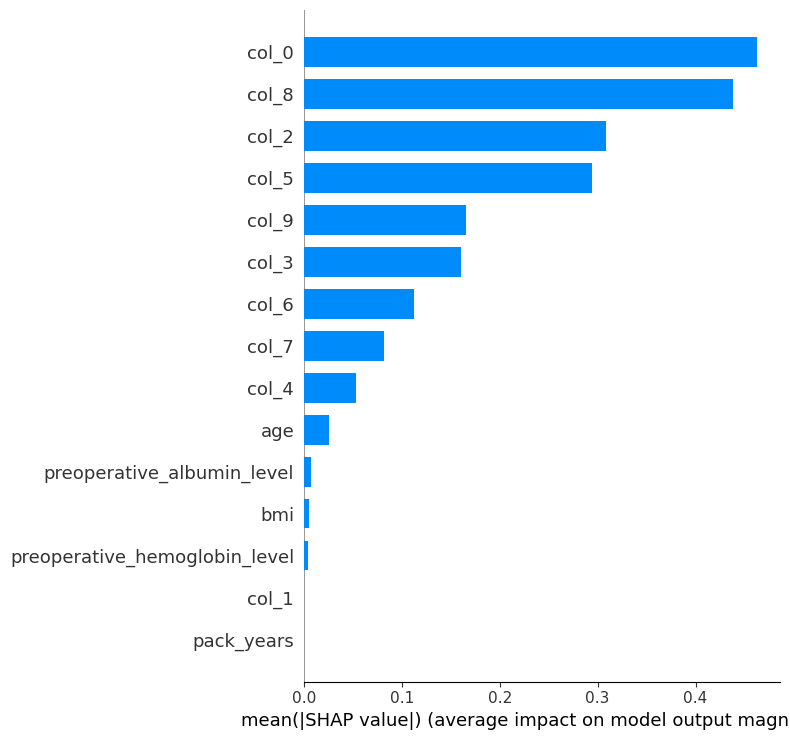

In [32]:
# Summary plot for class 0
shap.summary_plot(shap_values[: , : , 0],
                  plot_type = 'bar',
                  feature_names = X.columns.tolist(),
                 title = 'Feature Importance for Class 0')

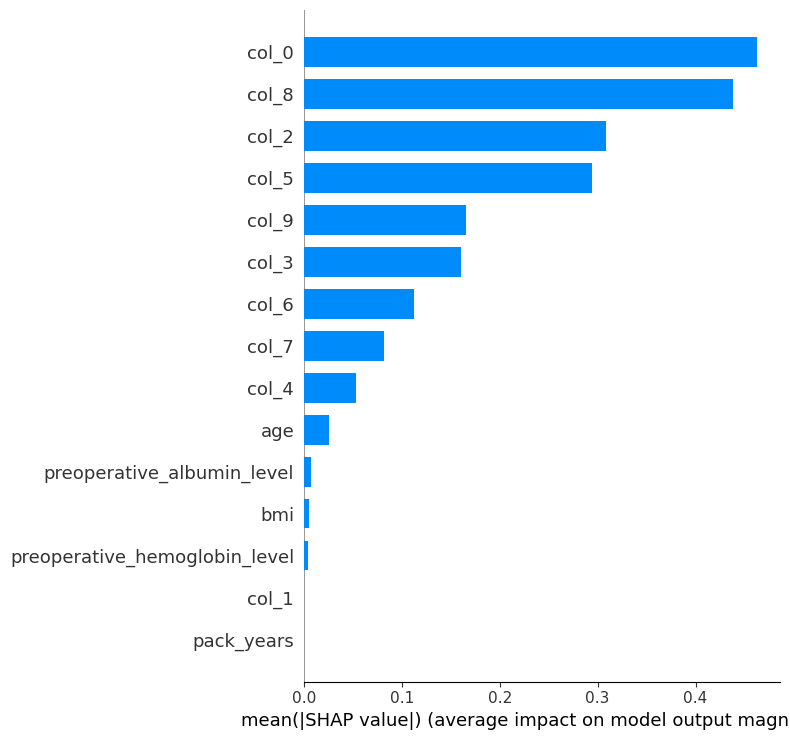

In [33]:
# Summary plot for class 1
shap.summary_plot(shap_values[: , : , 1],
                  plot_type = 'bar',
                  feature_names = X.columns.tolist(),
                 title = 'Feature Importance for Class 0')